#**DESCRIPTIVE AND CLASSIFICATION TIMEOUT ANALYSIS IN BASKETBALL**

**Project description**

The following code cells provide a descriptive analysis and a classification of basketball timeout data, concretely in the 2022-2023 ACB season

**Contact**: miquelvillaro2000@gmail.com


## 1. Data Wrangling
Some data preprocessing has already been done directly to the database (feature filter, noisy entries removal...).

In [64]:
# Imports

import sys
print("Python version:", sys.version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os

# Modeling libraries and functions
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Estudis/Màster BDA_SM/TFM/Dades/pbp_2223.csv') # Change directory
df_teams = pd.read_csv('/content/drive/MyDrive/Estudis/Màster BDA_SM/TFM/Dades/partidos_acb_22_23.csv') # Change directory
df.head()

Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,idLiga,liga,idPartido,idEquipo0,idEquipo1,idEquipoAccion,orden_accion,gt,s1,s2,...,actionNumber,previousAction,id_accion,actionType,qualifier,subType,scoring,assist,shirtNumber,scoreboardName
0,107,Liga Endesa,103146,4159,4150,NaN,59501,0:00,107,89,...,59501,NaN,516,Firma comisario,NaN,NaN,0,NaN,NaN,R. Méndez
1,107,Liga Endesa,103169,4148,4144,NaN,53101,0:00,81,68,...,53101,NaN,518,Firma cronometrador,NaN,NaN,0,NaN,NaN,NaN
2,107,Liga Endesa,103146,4159,4150,NaN,59701,0:00,107,89,...,59701,NaN,515,Firma árbitro,NaN,NaN,0,NaN,69.0,J. Torres
3,107,Liga Endesa,103145,4153,4144,NaN,51101,0:00,71,87,...,51101,NaN,515,Firma árbitro,NaN,NaN,0,NaN,57.0,S. Manuel
4,107,Liga Endesa,103323,4154,4145,NaN,68001,0:00,107,103,...,68001,NaN,515,Firma árbitro,NaN,NaN,0,NaN,75.0,R. Lucas


Rename columns and map team codes:

In [65]:
df = df.rename(columns={'idEquipo0': 'home_TeamId', 'idEquipo1': 'away_TeamId'})

# Input team codes
team_code_map = df_teams.set_index('home_TeamId')['home_TeamCode'].to_dict()

df['home_TeamCode'] = df['home_TeamId'].map(team_code_map)
df['away_TeamCode'] = df['away_TeamId'].map(team_code_map)

# Team codes
team_code_map

{4149: 'RMB',
 4156: 'VBC',
 4159: 'GCA',
 4150: 'UCM',
 4146: 'FUE',
 4157: 'JOV',
 4147: 'BAR',
 4153: 'BRE',
 4158: 'LNT',
 4160: 'COV',
 4143: 'GIR',
 4155: 'BAX',
 4151: 'MOB',
 4154: 'BKN',
 4148: 'SBB',
 4152: 'UNI',
 4145: 'BET',
 4144: 'CAZ'}

In [66]:
# Check if there are any noisy entries (repeated codes)
print('There are', len(df[df['home_TeamCode'] == df['away_TeamCode']]), 'repeated entries')

There are 0 repeated entries


Redundant column filtering (remove columns that present the same value for all entries or the same information as other columns):

In [67]:
duplicate_columns = []
columns = df.columns

# Compare columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        if df[columns[i]].equals(df[columns[j]]):
            print('Column', columns[j], 'is a duplicate of column', columns[i], '\n')
            duplicate_columns.append(columns[j])

columns_all_same = [col for col in df.columns if df[col].nunique() == 1]
print('Columns with all-same values:', columns_all_same, '\n')

df.info()

Column actionNumber is a duplicate of column orden_accion 

Column shirtNumber is a duplicate of column pno 

Column playersTeam2 is a duplicate of column playersTeam1 

Column assist is a duplicate of column playersTeam1 

Column assist is a duplicate of column playersTeam2 

Columns with all-same values: ['liga'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187306 entries, 0 to 187305
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   idLiga          187306 non-null  int64  
 1   liga            187306 non-null  object 
 2   idPartido       187306 non-null  int64  
 3   home_TeamId     187306 non-null  int64  
 4   away_TeamId     187306 non-null  int64  
 5   idEquipoAccion  179724 non-null  float64
 6   orden_accion    187306 non-null  int64  
 7   gt              187277 non-null  object 
 8   s1              187306 non-null  int64  
 9   s2              187306 non-null  int64  
 10  lead         

Column removal and dataframe sorting:

In [68]:
# Eliminate columns with redundant information
df = df.drop(['playersTeam1', 'playersTeam2', 'assist', 'orden_accion', 'pno', 'liga'], axis = 1)

# ...and more columns with no information at all or useless data
df = df.drop(['player', 'previousAction', 'shirtNumber', 'tno', 'periodType', 'success', 'previousAction', 'scoring', 'shirtNumber'], axis = 1)#info()

# Convert format to extract minutes and seconds
df['gt'] = pd.to_datetime(df['gt'], format='%M:%S').dt.time

# Sort dataframe: Game --> Period --> Time --> Action
df_sorted = df.sort_values(by=['idPartido', 'period', 'gt', 'actionNumber'], ascending = [True, True, False, True])

# Remove null entries at gt column
df_sorted = df_sorted.dropna(subset=['gt'])

# Extract minutes and seconds from gt
df_sorted[['hours', 'minutes', 'seconds']] = df_sorted['gt'].astype(str).str.split(':').tolist()
df_sorted.drop(columns=['hours'], inplace=True)
df_sorted['minutes'] = df_sorted['minutes'].astype(int)
df_sorted['seconds'] = df_sorted['seconds'].astype(int)

# Main TO information df
df_timeouts = df_sorted[df_sorted['actionType'] == 'timeout']
df_timeouts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2165 entries, 93330 to 66099
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   idLiga          2165 non-null   int64  
 1   idPartido       2165 non-null   int64  
 2   home_TeamId     2165 non-null   int64  
 3   away_TeamId     2165 non-null   int64  
 4   idEquipoAccion  2146 non-null   float64
 5   gt              2165 non-null   object 
 6   s1              2165 non-null   int64  
 7   s2              2165 non-null   int64  
 8   lead            2165 non-null   int64  
 9   period          2165 non-null   int64  
 10  tiempoPosesion  2165 non-null   int64  
 11  idPlayer        2165 non-null   int64  
 12  actionNumber    2165 non-null   int64  
 13  id_accion       2165 non-null   int64  
 14  actionType      2165 non-null   object 
 15  qualifier       2165 non-null   object 
 16  subType         2165 non-null   object 
 17  scoreboardName  2165 non-null   o

Copy and execute this code to download the sorted and filtered database:

```
df_timeouts.to_excel('dataframe.xlsx', index=False)  # index=False avoids writing row numbers
```



## Descriptive Analysis
Extract play/action information previous to the timeout:

In [70]:
# Filter by ID
non_accepted_action_ids = [112, 115, 598, 123, 511, 512] # Non-playing actions

# Label to classify if it's a team TO or not
timeout_id = 113 # Team TO ID
string_mask = df_sorted['id_accion'] == timeout_id

# Find index of each TO at database
string_indices = df_sorted.index[string_mask]

# Store list of each previous index to every TO
valid_previous_indices = []
same_team_TO = [] # Identiy if the action is played by the same team that calls the TO

for idx in string_indices:
    # Check previous indices
    i = idx - 1
    while i >= 0:  # Avoid going off-limits
        if df_sorted.loc[i, 'id_accion'] not in non_accepted_action_ids:  # Check if it's an accepted action
            valid_previous_indices.append(i)
            if df_sorted.loc[i]['idEquipoAccion'] == df_sorted.loc[idx]['idEquipoAccion']:
              same_team_TO.append(1)
            else:
              same_team_TO.append(0)
            break  # Stop when it finds a game action
        i -= 1  # Keep looking backwards if it doesn't find any

# Store a df with only the previous actions
df_valid_previous_rows = df_sorted.loc[valid_previous_indices]
df_valid_previous_rows['Same_Team_TO'] = same_team_TO

df_valid_previous_rows.head()

,idLiga,idPartido,home_TeamId,away_TeamId,idEquipoAccion,gt,s1,s2,lead,period,...,id_accion,actionType,qualifier,subType,scoreboardName,home_TeamCode,away_TeamCode,minutes,seconds,Same_Team_TO
93329,107,103139,4146,4145,4145.0,00:08:18,0,8,-8,1,...,108,assist,108 - Asistencia tiro de 3 - Assist 3-Point Shot,NaN,A. Cvetkovic,FUE,BET,8,18,0
93146,107,103139,4146,4145,4146.0,00:04:07,17,16,1,1,...,110,foulon,110 - Falta recibida - Foul Received,NaN,L. Kromah,FUE,BET,4,7,0
93378,107,103139,4146,4145,4146.0,00:01:23,38,37,1,2,...,107,assist,107 - Asistencia tiro de 2 - Assist 2-Point Shot,NaN,J. Senglin,FUE,BET,1,23,0
93194,107,103139,4146,4145,4146.0,00:05:40,55,44,11,3,...,107,assist,107 - Asistencia tiro de 2 - Assist 2-Point Shot,NaN,L. Kromah,FUE,BET,5,40,0
93079,107,103139,4146,4145,4146.0,00:03:37,57,51,6,3,...,104,rebound,104 - Rebote Defensivo - Defensive Rebound,defensive,D. Bertans,FUE,BET,3,37,1


Extract timeout previous action frequency:
- Same_Team_TO = 0 --> Action played by the opposing team
- Same_Team_TO = 1 --> Action played by the same team

In [71]:
df_valid_previous_rows[['qualifier', 'Same_Team_TO']].value_counts() # actionType

,,count
qualifier,Same_Team_TO,
107 - Asistencia tiro de 2 - Assist 2-Point Shot,0,455
108 - Asistencia tiro de 3 - Assist 3-Point Shot,0,382
93 - Canasta de 2 - 2-Point Shot Made,0,342
110 - Falta recibida - Foul Received,0,189
94 - Canasta de 3 - 3-Point Shot Made,0,121
92 - Canasta de 1 - Free Throw Made,0,114
130 - Contraataque 2pt - Fast break 2PT,0,80
110 - Falta recibida - Foul Received,1,63
106 - Pérdida - Turnover,0,51


Function definitions:

In [72]:
# Remaining seconds of the game to obtain a cronological action order of the entire game
def seconds_left(row):
  seconds_ind_per_left = row['minutes'] * 60 + row['seconds']

  if row['period'] == 1:
    seconds_ind_per_left += 1800

  elif row['period'] == 2:
    seconds_ind_per_left += 1200

  elif row['period'] == 3:
    seconds_ind_per_left += 600

  elif row['period'] == 0:
    seconds_ind_per_left = 2400

  return seconds_ind_per_left


# Function to change the score differential (+ or -) depending on the team's perspective (+5 for a team but -5 for the rival)
def lead_team(row, id):
  if row['home_TeamId'] == id:
    return row['lead']
  else:
    return row['lead']*(-1)

Extract lead variations throughout the games while marking the timeouts. We need to create and operate on a "play-only" database (only playing time actions):

Team codes:
 {4149: 'RMB', 4156: 'VBC', 4159: 'GCA', 4150: 'UCM', 4146: 'FUE', 4157: 'JOV', 4147: 'BAR', 4153: 'BRE', 4158: 'LNT', 4160: 'COV', 4143: 'GIR', 4155: 'BAX', 4151: 'MOB', 4154: 'BKN', 4148: 'SBB', 4152: 'UNI', 4145: 'BET', 4144: 'CAZ'}
Selected team ID: 4149


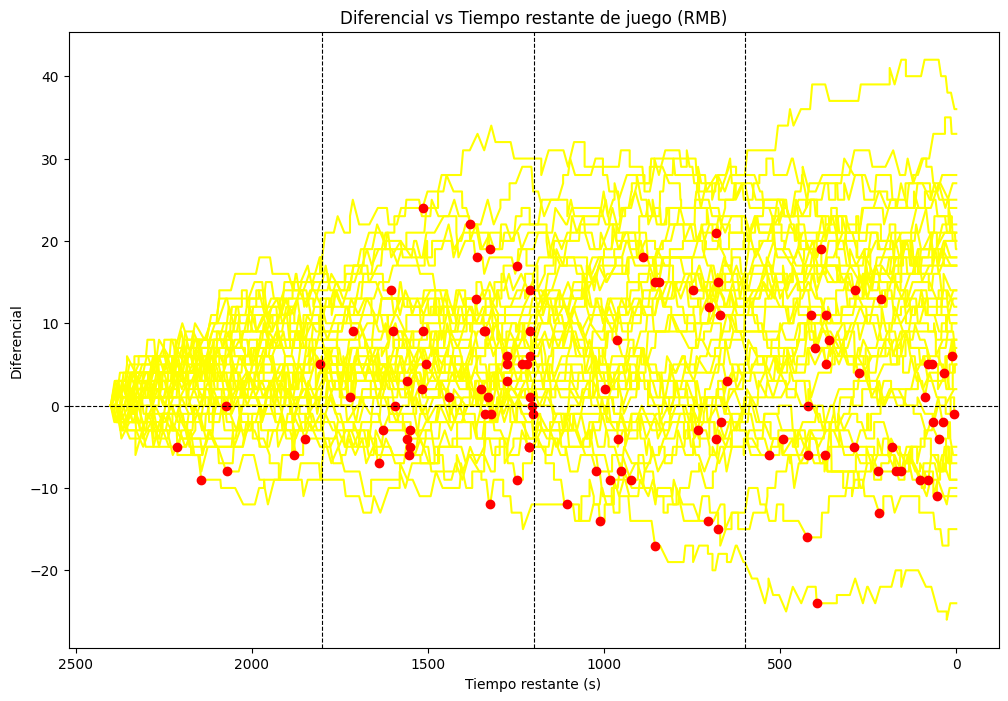

In [73]:
# Create df with only play actions
df_playtime = df_sorted[~df_sorted['id_accion'].isin(non_accepted_action_ids)] # Use the previous ID elimination list
df_playtime = df_playtime[~df_playtime['qualifier'].isna()]# Eliminate referee actions, game burocracy, etc.

print('Team codes:\n', team_code_map)
team_id = int(input('Selected team ID: '))

prova = df_playtime[(df_playtime['home_TeamId'] == team_id) | (df_playtime['away_TeamId'] == team_id)] # Select
prova['lead_bo'] = prova.apply(lambda row: lead_team(row, team_id), axis=1)
prova['total_secs'] = prova.apply(seconds_left, axis = 1)

specific_id = 113
team = team_code_map[team_id] # Select team depending on the given ID

groups = prova.groupby('idPartido') # Group by game

plt.figure(figsize=(12, 8))
for name, group in groups:
    plt.plot(group['total_secs'], group['lead_bo'], color = 'yellow', label=name, zorder = 1) # Plot for each game differential
    specific_points = group[(group['id_accion'] == specific_id) & (group['idEquipoAccion'] == team_id)]
    if not specific_points.empty:
        plt.scatter(specific_points['total_secs'], specific_points['lead_bo'], color='red', label=f"ID {specific_id}", zorder = 2) # Plot TOs

# Plot period time limits
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at y=0
plt.axvline(600, color='black', linewidth=0.8, linestyle='--')  # Vertical line at start of Q4
plt.axvline(1200, color='black', linewidth=0.8, linestyle='--')  # Vertical line at start of Q3
plt.axvline(1800, color='black', linewidth=0.8, linestyle='--')  # Vertical line at start of Q2

plt.gca().invert_xaxis()
plt.xlabel('Tiempo restante (s)')
plt.ylabel('Diferencial')
plt.title('Diferencial vs Tiempo restante de juego ({})'.format(team))

plt.show()

### Success Metric
Classify actions as positive, negative or neutral for each team depending on the play's ID (*qualifier*)

In [74]:
df_playtime.qualifier.value_counts() # Extract IDs

,count
qualifier,
104 - Rebote Defensivo - Defensive Rebound,16136
110 - Falta recibida - Foul Received,12891
93 - Canasta de 2 - 2-Point Shot Made,11359
97 - Intento fallado de 2 - 2-Point Shot Missed,11289
98 - Intento fallado de 3 - 3-Point Shot Missed,11049
92 - Canasta de 1 - Free Throw Made,9133
106 - Pérdida - Turnover,8498
101 - Rebote Ofensivo - Offensive Rebound,6725
94 - Canasta de 3 - 3-Point Shot Made,5827


In [75]:
# Classify IDs
success_play_ids = [104, 110, 93, 92, 101, 94, 107, 103, 108, 102, 100, 130, 119, 178, 134, 131]
unsuccessful_play_ids = [97, 98, 106, 161, 96, 135, 105, 160, 109, 179, 166, 162, 533, 537, 540, 132, 544, 133, 173, 165, 556, 168, 163, 543, 545]
neutral = [159, 113, 116, 121, 122, 405]  # PF_noFT, Timeout, end/start_period/game, VAR/Coach Challenge

# Assign success, no-success or neutral action type
def successful_play(row, team_type):
    team_id = row[f'{team_type}_TeamId']  # Home or away

    if row['id_accion'] in success_play_ids:
        return 1 if row['idEquipoAccion'] == team_id else 0
    elif row['id_accion'] in unsuccessful_play_ids:
        return 0 if row['idEquipoAccion'] == team_id else 1
    else:
        return 0.5

df_playtime['home_Success'] = df_playtime.apply(successful_play, axis=1, team_type='home')
df_playtime['away_Success'] = df_playtime.apply(successful_play, axis=1, team_type='away')

Compute team success for the previous 10 and next 10 actions (for every play), except if it finds another TO or an end of quarter (in this case, compute the overall success until that point). Rival team success will be calculated through *S2 = 1 - Rival_Success*

In [76]:
df_playtime = df_playtime.reset_index(drop=True)

########## LAST 10 SUCCESS ##########
prev_n_mean = []

for idx in range(len(df_playtime)):
    current_game_id = df_playtime.loc[idx, 'idPartido']
    sum_success = 0
    count = 0
    for i in range(1, 10):
        if idx - i <= 0:
            break
        if df_playtime.loc[idx - i, 'idPartido'] == current_game_id and df_playtime.loc[idx - i, 'id_accion'] != 113:
            sum_success += df_playtime.loc[idx - i, 'home_Success']
            count += 1
        else:
            break

    mean = sum_success / count if count > 0 else 0
    prev_n_mean.append(mean)

df_playtime['home_last_10_success'] = prev_n_mean
df_playtime['away_last_10_success'] = 1 - df_playtime['home_last_10_success']

########## NEXT 10 SUCCESS ##########
next_n_mean = []

for idx in range(len(df_playtime)):
    current_game_id = df_playtime.loc[idx, 'idPartido']
    sum_success = 0
    count = 0
    for i in range(1, 10):
        if idx + i >= len(df_playtime):
            break
        if df_playtime.loc[idx + i, 'idPartido'] == current_game_id and df_playtime.loc[idx + i, 'id_accion'] != 113:
            sum_success += df_playtime.loc[idx + i, 'home_Success']
            count += 1
        else:
            break

    mean = sum_success / count if count > 0 else 0
    next_n_mean.append(mean)

df_playtime['home_next_10_success'] = next_n_mean
df_playtime['away_next_10_success'] = 1 - df_playtime['home_next_10_success']

df_playtime.head()

,idLiga,idPartido,home_TeamId,away_TeamId,idEquipoAccion,gt,s1,s2,lead,period,...,home_TeamCode,away_TeamCode,minutes,seconds,home_Success,away_Success,home_last_10_success,away_last_10_success,home_next_10_success,away_next_10_success
0,107,103139,4146,2000,4146.0,00:10:00,0,0,0,1,...,FUE,NaN,10,0,0.5,0.5,0.0,1.0,0.500000,0.500000
1,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,FUE,BET,10,0,0.5,0.5,0.0,1.0,0.500000,0.500000
2,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,FUE,BET,10,0,0.5,0.5,0.5,0.5,0.500000,0.500000
3,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,FUE,BET,10,0,0.5,0.5,0.5,0.5,0.444444,0.555556
4,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,FUE,BET,10,0,0.5,0.5,0.5,0.5,0.388889,0.611111


### Scoring Streaks
Compute last 4 scores' differential for each play to evaluate the streaks before the timeouts:

In [77]:
##### Previous streak #####
last_4_scores = []

# Iterate over the DataFrame
for idx in range(len(df_playtime)):
    current_game_id = df_playtime.at[idx, 'idPartido']
    current_lead = df_playtime.at[idx, 'lead']
    s1_current = df_playtime.at[idx, 's1']
    s2_current = df_playtime.at[idx, 's2']

    found = False  # Keep track if a valid lead difference was found
    j = 0
    for i in range(1, 30):
        previous_idx = idx - i
        if previous_idx < 0:  # Break the loop if index is out of bounds
            break

        # Access previous row data
        prev_row = df_playtime.iloc[previous_idx]

        if (
            prev_row['idPartido'] == current_game_id
            and prev_row['id_accion'] != 113
            and prev_row['s1'] != s1_current
            and prev_row['s2'] != s2_current
        ):
          j += 1
          if j == 4: # If it's the 4th score, end it and append the lead differential to the list
              lead_dif = current_lead - prev_row['lead']
              last_4_scores.append(lead_dif)
              found = True
              break

    # If no valid lead difference was found, append 0
    if not found:
        last_4_scores.append(0)

# Add the last_4_scores list as a new column to the DataFrame
df_playtime['last_4_scores'] = last_4_scores

Compute next 4 scores' differential for each play to evaluate the streaks after the timeouts:

In [78]:
##### Next streak #####
next_4_scores = []

# Iterate over the DataFrame
for idx in range(len(df_playtime)):
    current_game_id = df_playtime.at[idx, 'idPartido']
    current_lead = df_playtime.at[idx, 'lead']
    s1_current = df_playtime.at[idx, 's1']
    s2_current = df_playtime.at[idx, 's2']

    found = False  # Keep track if a valid lead difference was found
    j = 0
    for i in range(1, 30):
        next_idx = idx + i
        if next_idx > len(df_playtime) - 1:  # Break the loop if index is out of bounds
            break

        # Access next row data
        next_row = df_playtime.iloc[next_idx]

        if (
            next_row['idPartido'] == current_game_id
            and next_row['id_accion'] != 113
            and next_row['s1'] != s1_current
            and next_row['s2'] != s2_current
        ):
          j += 1
          if j == 4: # If it's the 4th score, end it and append the lead differential to the list
              lead_dif = next_row['lead'] - current_lead
              next_4_scores.append(lead_dif)
              found = True
              break

    # If no valid lead difference was found, append 0
    if not found:
        next_4_scores.append(0)

# Add the next_4_scores list as a new column to the DataFrame
df_playtime['next_4_scores'] = next_4_scores

### Next Play Evaluation
Compute next action (and the team that plays it) for each entry to evaluate the frequency of ATO plays:

In [79]:
df_playtime['next_play'] = df_playtime['qualifier'].shift(-1)
df_playtime['team_id_next_play'] = df_playtime['idEquipoAccion'].shift(-1)
df_playtime['team_id_next_play'] = df_playtime['team_id_next_play'].map(team_code_map)

df_playtime.head()

,idLiga,idPartido,home_TeamId,away_TeamId,idEquipoAccion,gt,s1,s2,lead,period,...,home_Success,away_Success,home_last_10_success,away_last_10_success,home_next_10_success,away_next_10_success,last_4_scores,next_4_scores,next_play,team_id_next_play
0,107,103139,4146,2000,4146.0,00:10:00,0,0,0,1,...,0.5,0.5,0.0,1.0,0.500000,0.500000,0,0,599 - Cinco Inicial - Starting Five,BET
1,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,0.5,0.5,0.0,1.0,0.500000,0.500000,0,0,599 - Cinco Inicial - Starting Five,BET
2,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,0.5,0.5,0.5,0.5,0.500000,0.500000,0,0,599 - Cinco Inicial - Starting Five,BET
3,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,0.5,0.5,0.5,0.5,0.444444,0.555556,0,-5,599 - Cinco Inicial - Starting Five,BET
4,107,103139,4146,4145,4145.0,00:10:00,0,0,0,1,...,0.5,0.5,0.5,0.5,0.388889,0.611111,0,-5,599 - Cinco Inicial - Starting Five,BET


Filter TV timeouts:

In [95]:
to_id = [113, 118]
df_timeouts = df_playtime[df_playtime['id_accion'].isin(to_id)]
df_timeouts.id_accion.value_counts()

,count
id_accion,
113,2146
118,19


Team timeouts' next play frequency and final timeout dataframe creation:

In [96]:
# TV and team TOs
df_timeouts_COMM = df_timeouts[df_timeouts['id_accion'] == 118]
df_timeouts = df_timeouts[df_timeouts['id_accion'] == 113] # Used database in further analysis
df_timeouts.next_play.value_counts()

,count
next_play,
98 - Intento fallado de 3 - 3-Point Shot Missed,376
97 - Intento fallado de 2 - 2-Point Shot Missed,364
93 - Canasta de 2 - 2-Point Shot Made,320
106 - Pérdida - Turnover,254
94 - Canasta de 3 - 3-Point Shot Made,203
161 - Personal 2TL - Foul 2FT,161
159 - Personal no TL - Foul No FT,159
92 - Canasta de 1 - Free Throw Made,138
96 - Intento fallado de 1 - Free Throw Missed,58


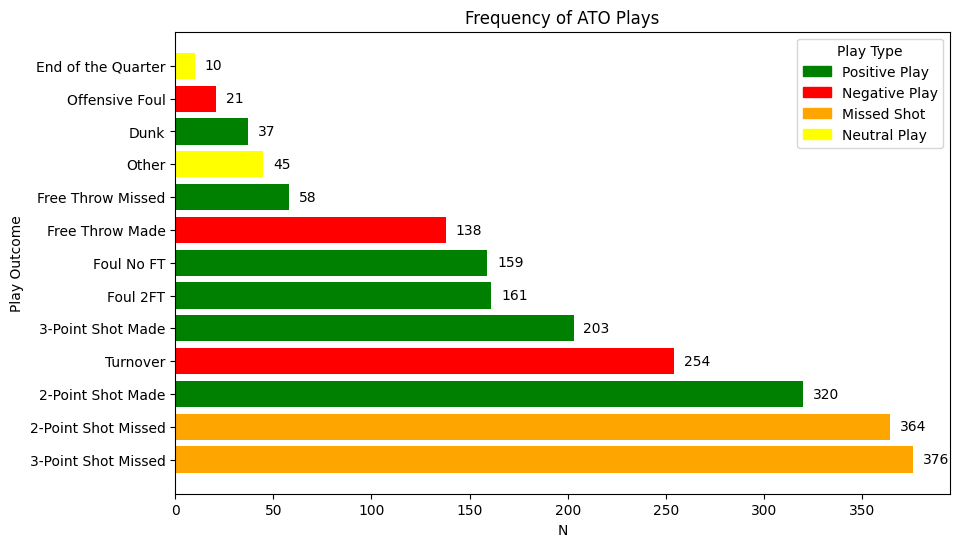

In [97]:
# Create chart with previous frequency data:
data = {
    'Next Play': ['3-Point Shot Missed', '2-Point Shot Missed', '2-Point Shot Made', 'Turnover', '3-Point Shot Made',
                  'Foul 2FT', 'Foul No FT', 'Free Throw Made', 'Free Throw Missed', 'Dunk', 'Offensive Foul',
                  'End of the Quarter', 'Other'],
    'N': [376, 364, 320, 254, 203, 161, 159, 138, 58, 37, 21, 10, 45]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by frewquency
df = df.sort_values('N', ascending=False)

# Custom colors for each category of plays
colors = ['orange', 'orange', 'green', 'red', 'green', 'green', 'green', 'red', 'green', 'yellow', 'green', 'red', 'yellow']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(df['Next Play'], df['N'], color=colors)

# Labels
plt.xlabel('N')
plt.ylabel('Play Outcome')
plt.title('Frequency of ATO Plays')

# Add the frequencies at the end of each bar
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}', va='center')

# Legend
legend_patches = [
    mpatches.Patch(color='green', label='Positive Play'),
    mpatches.Patch(color='red', label='Negative Play'),
    mpatches.Patch(color='orange', label='Missed Shot'),
    mpatches.Patch(color='yellow', label='Neutral Play')
]

plt.legend(handles=legend_patches, loc='upper right', title="Play Type")
plt.show()

TV timeouts brief description:

In [98]:
df_timeouts_COMM.drop(['idLiga', 'idPartido', 'home_TeamId', 'away_TeamId', 'idEquipoAccion'], axis = 1).describe()

,s1,s2,lead,period,tiempoPosesion,idPlayer,actionNumber,id_accion,minutes,seconds,home_Success,away_Success,home_last_10_success,away_last_10_success,home_next_10_success,away_next_10_success,last_4_scores,next_4_scores
count,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,19.000000,19.0,19.000000,19.000000,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,41.000000,39.473684,1.526316,2.526316,4.526316,2.484773e+07,26564.263158,118.0,3.947368,47.157895,0.5,0.5,0.426901,0.573099,0.475355,0.524645,-0.052632,0.421053
std,21.941842,18.804162,8.675434,0.904828,7.633031,5.022642e+06,12578.098164,0.0,0.229416,8.132672,0.0,0.0,0.226844,0.226844,0.259784,0.259784,2.067572,3.920258
min,19.000000,17.000000,-17.000000,2.000000,0.000000,2.020173e+07,17201.000000,118.0,3.000000,30.000000,0.5,0.5,0.000000,0.111111,0.111111,0.111111,-3.000000,-8.000000
25%,28.500000,29.000000,-2.000000,2.000000,0.000000,2.021211e+07,18851.000000,118.0,4.000000,40.500000,0.5,0.5,0.305556,0.472222,0.250000,0.333333,-1.000000,-2.000000
50%,34.000000,32.000000,-1.000000,2.000000,0.000000,2.021303e+07,19801.000000,118.0,4.000000,48.000000,0.5,0.5,0.444444,0.555556,0.388889,0.611111,0.000000,0.000000
75%,41.500000,48.500000,4.500000,3.000000,4.000000,3.000061e+07,31451.000000,118.0,4.000000,54.500000,0.5,0.5,0.527778,0.694444,0.666667,0.750000,0.500000,2.000000
max,91.000000,86.000000,20.000000,4.000000,25.000000,3.000203e+07,51301.000000,118.0,4.000000,59.000000,0.5,0.5,0.888889,1.000000,0.888889,0.888889,4.000000,8.000000


### Time Relationships
Multiple plots showing timeout data through gametime. First of all, minute-wise (independently of the period):

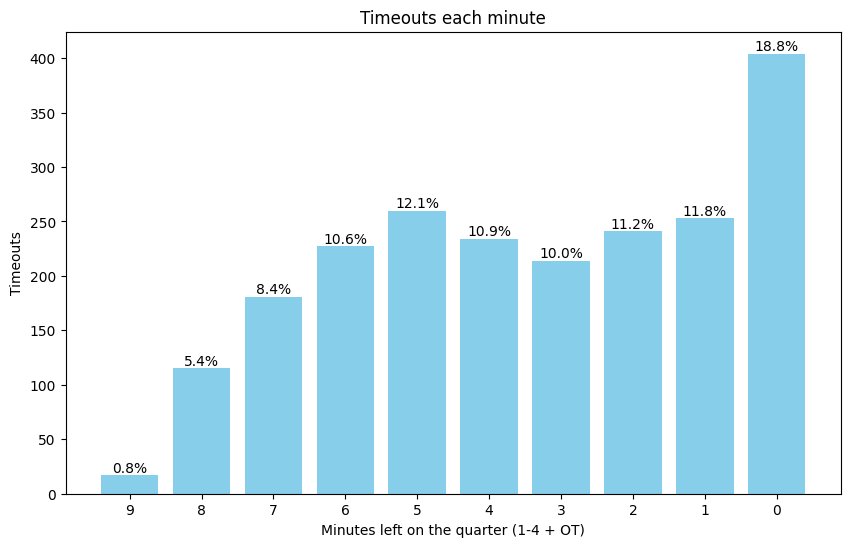

In [99]:
# Charts
def chart_TOs(df):
  frequency = df['minutes'].value_counts()

  # Plot
  plt.figure(figsize=(10, 6))
  bars = plt.bar(frequency.index, frequency.values, color='skyblue')

  # Labels
  for bar in bars:
      yval = bar.get_height()
      plt.text((bar.get_x() + bar.get_width()/2), yval, str(np.round(yval/len(df)*100, 1)) + '%', ha='center', va='bottom')

  plt.xticks(range(0, 10))

  # Invert axis
  plt.gca().invert_xaxis()

  plt.xlabel('Minutes left on the quarter (1-4 + OT)')
  plt.ylabel('Timeouts')
  plt.title('Timeouts each minute')
  plt.show()

chart_TOs(df_timeouts)

Segment by quarter:

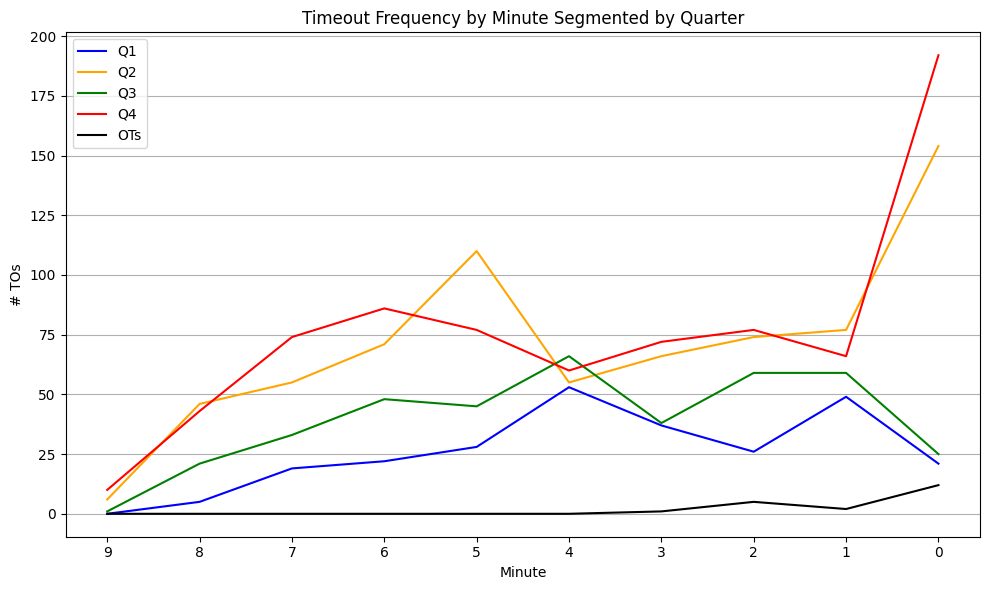

In [100]:
# Separate periods
df_1st = df_timeouts[df_timeouts['period'] == 1]
df_2nd = df_timeouts[df_timeouts['period'] == 2]
df_3rd = df_timeouts[df_timeouts['period'] == 3]
df_4th = df_timeouts[df_timeouts['period'] == 4]
df_OTs = df_timeouts[df_timeouts['period'] > 4]

# Minute frequency
freq_df1 = df_1st['minutes'].value_counts()
freq_df2 = df_2nd['minutes'].value_counts()
freq_df3 = df_3rd['minutes'].value_counts()
freq_df4 = df_4th['minutes'].value_counts()
freq_df5 = df_OTs['minutes'].value_counts()

# Unique list
all_x_values = sorted(set(freq_df1.index).union(freq_df2.index).union(freq_df3.index).union(freq_df4.index).union(freq_df5.index))

# Index
freq_df1 = freq_df1.reindex(all_x_values, fill_value=0)
freq_df2 = freq_df2.reindex(all_x_values, fill_value=0)
freq_df3 = freq_df3.reindex(all_x_values, fill_value=0)
freq_df4 = freq_df4.reindex(all_x_values, fill_value=0)
freq_df5 = freq_df5.reindex(all_x_values, fill_value=0)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(all_x_values, freq_df1, label='Q1', color='blue')
plt.plot(all_x_values, freq_df2, label='Q2', color='orange')
plt.plot(all_x_values, freq_df3, label='Q3', color='green')
plt.plot(all_x_values, freq_df4, label='Q4', color='red')
plt.plot(all_x_values, freq_df5, label='OTs', color='black')

# Invert axis
plt.gca().invert_xaxis()

# Include all possible values (all quarter minutes)
plt.xticks(all_x_values)

plt.xlabel('Minute')
plt.ylabel('# TOs')
plt.title('Timeout Frequency by Minute Segmented by Quarter')

plt.legend()

plt.grid(axis = 'y')
plt.tight_layout()
plt.show()

### Lead Analysis

Lead mean when calling a timeout(from that team's point of view): -3.69


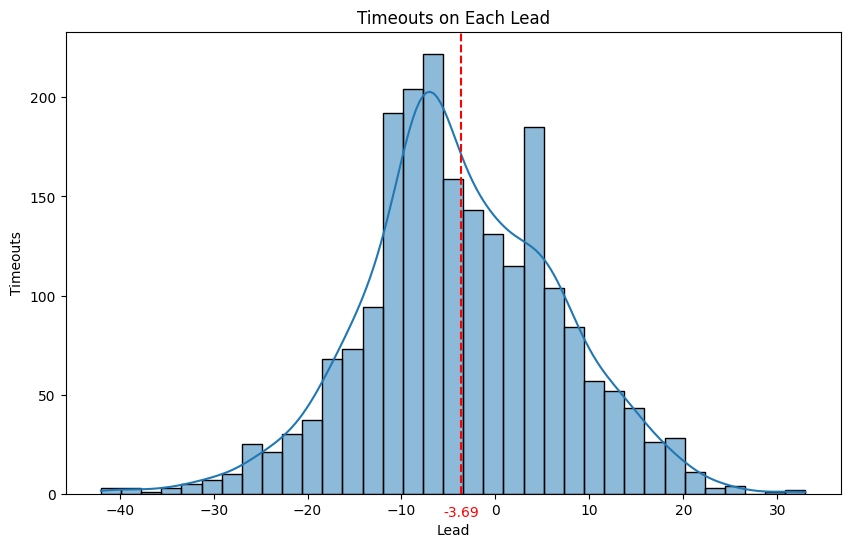

In [101]:
def team_TO_def(row):
  if row['idEquipoAccion'] == row['home_TeamId']:
    return row['home_TeamCode']
  else:
    return row['away_TeamCode']

df_timeouts['team_TO'] = df_timeouts.apply(team_TO_def, axis = 1)

def lead_team_TO_def(row):
  if row['team_TO'] == row['home_TeamCode']:
    return row['lead']
  else:
    return row['lead']*(-1)

df_timeouts['lead_of_Team_TO'] = df_timeouts.apply(lead_team_TO_def, axis = 1)
print("Lead mean when calling a timeout(from that team's point of view):", np.round(df_timeouts.lead_of_Team_TO.mean(), 2))

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_timeouts, x='lead_of_Team_TO', multiple='stack', kde=True)

mean_value = df_timeouts['lead_of_Team_TO'].mean()
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.text(mean_value, plt.gca().get_ylim()[0] - 0.05 * plt.gca().get_ylim()[1],
         f'{mean_value:.2f}', color='red', ha='center')

plt.xlabel('Lead')
plt.ylabel('Timeouts')
plt.title('Timeouts on Each Lead')
plt.show()

### Time Remaining vs Lead Differential Comparison

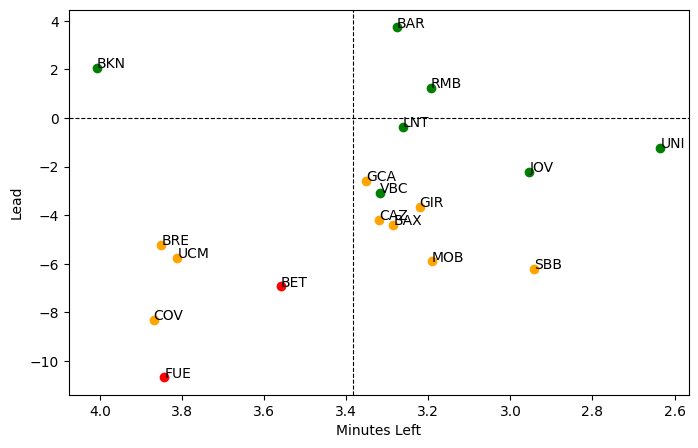

In [102]:
# Group by teams and compute minutes and diferential means
df_team_TO_Lead_GT = df_timeouts.groupby('team_TO')[['minutes', 'lead_of_Team_TO']].mean()

team_colors = {
    'BAR': 'green', 'BKN': 'green', 'RMB': 'green', 'LNT': 'green', 'UNI': 'green', 'JOV': 'green', 'VBC': 'green',
    'GCA': 'orange', 'GIR': 'orange', 'CAZ': 'orange', 'BAX': 'orange', 'MOB': 'orange', 'SBB': 'orange', 'BET': 'red', 'UCM': 'orange', 'BRE': 'orange', 'COV': 'orange', 'FUE': 'red',
}

# Create the scatter plot
plt.figure(figsize=(8, 5))

# Plot each team with its specific color
for team, color in team_colors.items():
    plt.scatter(df_team_TO_Lead_GT.loc[team, 'minutes'],
                df_team_TO_Lead_GT.loc[team, 'lead_of_Team_TO'],
                color=color, label=team)


plt.gca().invert_xaxis()

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal line at y=0
plt.axvline(np.mean(df_team_TO_Lead_GT['minutes']), color='black', linewidth=0.8, linestyle='--')  # Vertical line at mean of minutes left

# Labels
for i, txt in enumerate(df_team_TO_Lead_GT.index):
    plt.annotate(txt, (df_team_TO_Lead_GT['minutes'][i], df_team_TO_Lead_GT['lead_of_Team_TO'][i]))


plt.xlabel('Minutes Left')
plt.ylabel('Lead')
plt.show()

### Possession Left

Mean of possession left when calling a timeout: 15.75 s



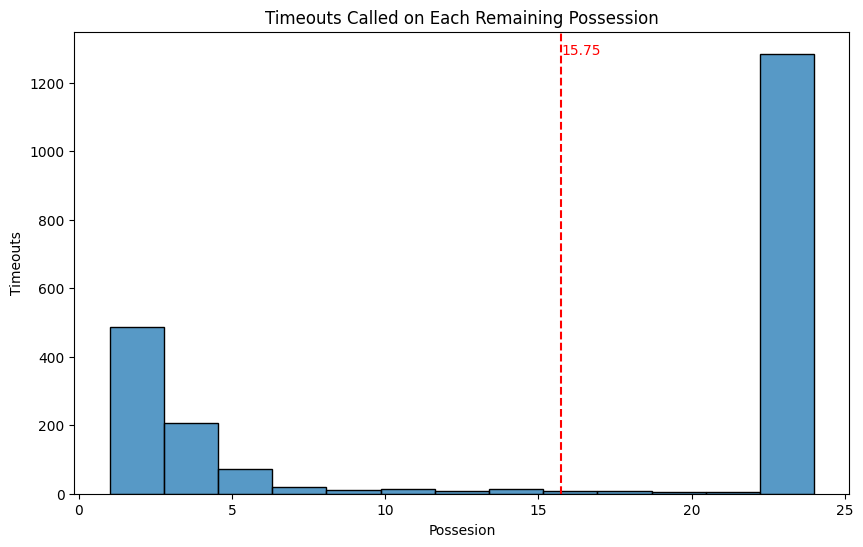

In [103]:
df_timeouts['total_seconds'] = df_timeouts.apply(seconds_left, axis = 1)
# Drop higher than 24" possessions
df_timeouts['tiempoPosesion'] = df_timeouts['tiempoPosesion'].apply(lambda x: 24 if x > 24 or x <= 0 else x)
print('Mean of possession left when calling a timeout:', np.round(df_timeouts.tiempoPosesion.mean(), 2), 's\n')

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_timeouts, x='tiempoPosesion')

mean_value = df_timeouts['tiempoPosesion'].mean()
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.text(mean_value, plt.gca().get_ylim()[-1] - 0.05 * plt.gca().get_ylim()[1],
         f'{mean_value:.2f}', color='red', ha='left')

plt.xlabel('Possesion')
plt.ylabel('Timeouts')
plt.title('Timeouts Called on Each Remaining Possession')
plt.show()

### Regular Season vs Playoffs
Compare lead vs time left when a timeout is called, including a separation between playoff and regular season games:

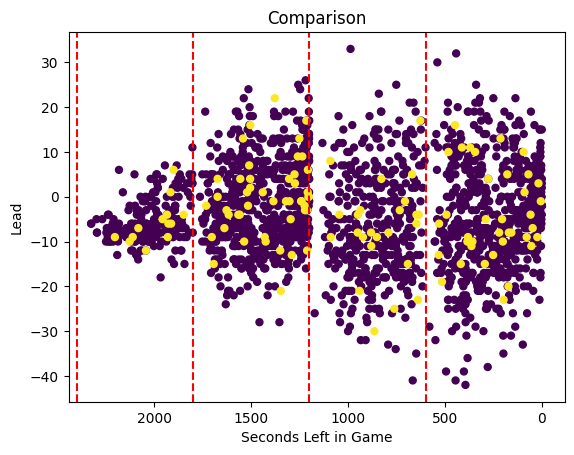

In [104]:
# Plot
plt.scatter(df_timeouts['total_seconds'], df_timeouts['lead_of_Team_TO'], c = df_timeouts['idLiga'], s=25)

# Add end of periods
plt.axvline(600, color='red', linestyle='--')
plt.axvline(1200, color='red', linestyle='--')
plt.axvline(1800, color='red', linestyle='--')
plt.axvline(2400, color='red', linestyle='--')

plt.gca().invert_xaxis()
plt.xlabel('Seconds Left in Game')
plt.ylabel('Lead')
plt.title('Comparison')

plt.show()

### Timeout After Timeout (ATO TOs)
Evaluate whether the timeout has been called immediately after another one or not:

In [105]:
timeout_inlast_10 = [0]

for i in range(1, len(df_timeouts)):
    # Check if there is a TO in the previous 10 actions, to look if there are consecutive TOs (usually in close game endings)
    if df_timeouts.index[i] - df_timeouts.index[i-1] > 10:
      timeout_inlast_10.append(0)
    else:
      timeout_inlast_10.append(1)

df_timeouts['timeout_inlast_10'] = timeout_inlast_10
df_timeouts.timeout_inlast_10.value_counts()

,count
timeout_inlast_10,
0,1984
1,162


Copy and execute this code to compare both types (consecutive and non-consecutive timeouts):

```
# Extract and compare data (switch between 0 (non-consecutive) and 1 (consecutive)
df_timeouts[df_timeouts['timeout_inlast_10'] == 1].drop(['idLiga', 'idPartido', 'home_TeamId', 'away_TeamId', 'idEquipoAccion', 'tiempoPosesion'], axis = 1).describe()
```



In [106]:
def Team_TO_last10_Success(row):
  if row['team_TO'] == row['home_TeamCode']:
    return row['home_last_10_success']
  else:
    return row['away_last_10_success']

def Team_TO_next10_Success(row):
  if row['team_TO'] == row['home_TeamCode']:
    return row['home_next_10_success']
  else:
    return row['away_next_10_success']

df_timeouts['TEAM_TO_LAST10_SUCCESS'] = df_timeouts.apply(Team_TO_last10_Success, axis = 1)
df_timeouts['TEAM_TO_NEXT10_SUCCESS'] = df_timeouts.apply(Team_TO_next10_Success, axis = 1)

df_timeouts.head()

,idLiga,idPartido,home_TeamId,away_TeamId,idEquipoAccion,gt,s1,s2,lead,period,...,last_4_scores,next_4_scores,next_play,team_id_next_play,team_TO,lead_of_Team_TO,total_seconds,timeout_inlast_10,TEAM_TO_LAST10_SUCCESS,TEAM_TO_NEXT10_SUCCESS
28,107,103139,4146,4145,4146.0,00:08:17,0,8,-8,1,...,0,1,94 - Canasta de 3 - 3-Point Shot Made,FUE,FUE,-8,2297,0,0.000000,0.333333
81,107,103139,4146,4145,4145.0,00:04:07,17,16,1,1,...,5,1,92 - Canasta de 1 - Free Throw Made,FUE,BET,-1,2047,0,0.111111,0.333333
213,107,103139,4146,4145,4145.0,00:01:23,38,37,1,2,...,2,-1,109 - Falta en Ataque - Offensive Foul,BET,BET,-1,1283,0,0.222222,0.444444
274,107,103139,4146,4145,4145.0,00:05:40,55,44,11,3,...,8,-2,166 - Antidep 2TL - Unsportsmanlike 2FT,FUE,BET,-11,940,0,0.277778,0.555556
296,107,103139,4146,4145,4146.0,00:03:37,57,51,6,3,...,-3,1,106 - Pérdida - Turnover,FUE,FUE,6,817,0,0.444444,0.444444


### Re-do column filtering
Now that we've reduced the initial dataframe, filter once more to delete unnecessary data:

In [109]:
# Same process as before, delete columns with redundant values and information
df_timeouts = df_timeouts.reset_index(drop=True)
df_valid_previous_rows = df_valid_previous_rows.reset_index(drop=True)
df_timeouts['previousAction'] = df_valid_previous_rows['qualifier']

duplicate_columns = []
columns = df_timeouts.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        if df_timeouts[columns[i]].equals(df_timeouts[columns[j]]):
            print('Column', columns[j], 'is a duplicate of column', columns[i], '\n')
            duplicate_columns.append(columns[j])

columns_all_same = [col for col in df_timeouts.columns if df_timeouts[col].nunique() == 1]
print('Columns with all-same values:', columns_all_same, '\n')

# Remove columns
df_timeouts = df_timeouts.drop(['id_accion', 'actionType', 'qualifier', 'subType',
                                'home_Success', 'away_Success', 'home_last_10_success',
                                'away_last_10_success', 'scoreboardName'],
                               axis = 1)#info()]

Column away_Success is a duplicate of column home_Success 

Columns with all-same values: ['id_accion', 'actionType', 'qualifier', 'subType', 'home_Success', 'away_Success'] 



### Called Timeout Number
For each team, 1st of the game, 2nd, 3rd...

In [111]:
df_timeouts['timeout_Number'] = 0
current_game = None
occurrence_count = {}  # Dictionary to count TOs

for idx, row in df_timeouts.iterrows():
    # If the game ID changes, reset to 0
    if row['idPartido'] != current_game:
        current_game = row['idPartido']
        occurrence_count = {}

    # Check the team that calls the TO
    value_a = row['team_TO']

    # If it's the first TO, add a 1, and if not, +1 to the stored value
    if value_a in occurrence_count:
        occurrence_count[value_a] += 1
    else:
        occurrence_count[value_a] = 1

    # If you don't use the seconds TO, eliminate it and the next one will be the 3rd (you lose one)
    if row['period'] > 2 and occurrence_count[value_a] < 3:
      occurrence_count[value_a] = 3

    # Same as before, if the 3rd is not spent before the last 2' at the last quarter, eliminate one as well
    if row['period'] == 4 and row['minutes'] < 2 and occurrence_count[value_a] < 4:
      occurrence_count[value_a] = 4

    # Overtimes
    if row['period'] > 4:
      occurrence_count[value_a] = row['period'] + 1

    # Assign the number of TO
    df_timeouts.at[idx, 'timeout_Number'] = occurrence_count[value_a]

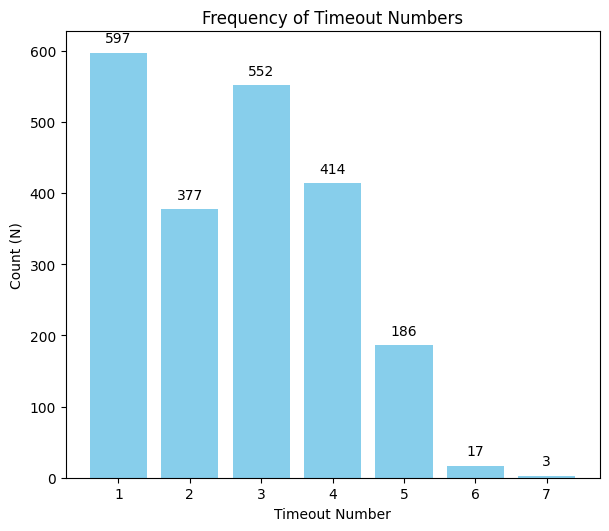

In [112]:
N_TOs = pd.DataFrame(df_timeouts.timeout_Number.value_counts()).reset_index()#.to_dataFrame()

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(N_TOs['timeout_Number'], N_TOs['count'], color='skyblue')
plt.tight_layout()

# Labels
plt.xlabel('Timeout Number')
plt.ylabel('Count (N)')
plt.title('Frequency of Timeout Numbers')

# Add frequencies at the top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, f'{int(bar.get_height())}', ha='center', va='bottom')

plt.show()

Copy and execute the following code to extract information and statistics of each timeout called:

```
timeout_number = 1 #Switch
df_timeouts[df_timeouts['timeout_Number'] == timeout_number].drop(['idLiga', 'idPartido', 'home_TeamId', 'away_TeamId', 'idEquipoAccion'], axis = 1).describe()
```

Compute streaks depending on the local team's point of view:

In [114]:
def lead_team_TO_def_2(row):
  if row['team_TO'] == row['home_TeamCode']:
    return row['last_4_scores']
  else:
    return row['last_4_scores']*(-1)

def lead_team_TO_def_3(row):
  if row['team_TO'] == row['home_TeamCode']:
    return row['next_4_scores']
  else:
    return row['next_4_scores']*(-1)

df_timeouts['lead'] = df_timeouts.apply(lead_team_TO_def, axis = 1)
df_timeouts['last_4_scores'] = df_timeouts.apply(lead_team_TO_def_2, axis = 1)
df_timeouts['next_4_scores'] = df_timeouts.apply(lead_team_TO_def_3, axis = 1)

df_timeouts.describe()

,idLiga,idPartido,home_TeamId,away_TeamId,idEquipoAccion,s1,s2,lead,period,tiempoPosesion,...,home_next_10_success,away_next_10_success,last_4_scores,next_4_scores,lead_of_Team_TO,total_seconds,timeout_inlast_10,TEAM_TO_LAST10_SUCCESS,TEAM_TO_NEXT10_SUCCESS,timeout_Number
count,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,...,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000,2146.000000
mean,107.225536,103306.314073,4151.490680,4151.506058,4151.346226,48.625349,46.391892,-3.688257,2.797763,15.751165,...,0.510029,0.489971,-2.168686,0.322460,-3.688257,959.581081,0.075489,0.262207,0.492870,2.663560
std,0.922862,103.808593,5.153599,5.112279,5.189812,24.117977,23.078072,10.454797,1.083513,10.353769,...,0.247229,0.247229,2.491097,2.188427,10.454797,659.392951,0.264241,0.209901,0.247330,1.345127
min,107.000000,103139.000000,4143.000000,4143.000000,4143.000000,0.000000,0.000000,-42.000000,1.000000,1.000000,...,0.000000,0.000000,-11.000000,-8.000000,-42.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,107.000000,103219.250000,4147.000000,4147.000000,4147.000000,29.000000,27.000000,-10.000000,2.000000,3.000000,...,0.333333,0.333333,-4.000000,-1.000000,-10.000000,334.000000,0.000000,0.111111,0.333333,1.000000
50%,107.000000,103302.000000,4152.000000,4151.000000,4151.000000,47.000000,45.000000,-5.000000,3.000000,24.000000,...,0.500000,0.500000,-2.000000,0.000000,-5.000000,965.000000,0.000000,0.222222,0.500000,3.000000
75%,107.000000,103382.000000,4156.000000,4156.000000,4156.000000,69.000000,66.000000,4.000000,4.000000,24.000000,...,0.666667,0.666667,0.000000,1.000000,4.000000,1505.750000,0.000000,0.388889,0.666667,4.000000
max,111.000000,103560.000000,4160.000000,4160.000000,4160.000000,110.000000,111.000000,33.000000,6.000000,24.000000,...,1.000000,1.000000,7.000000,12.000000,33.000000,2327.000000,1.000000,1.000000,1.000000,7.000000


### Scoring comparison before and after a timeout
Only take into account non-consecutive timeouts:

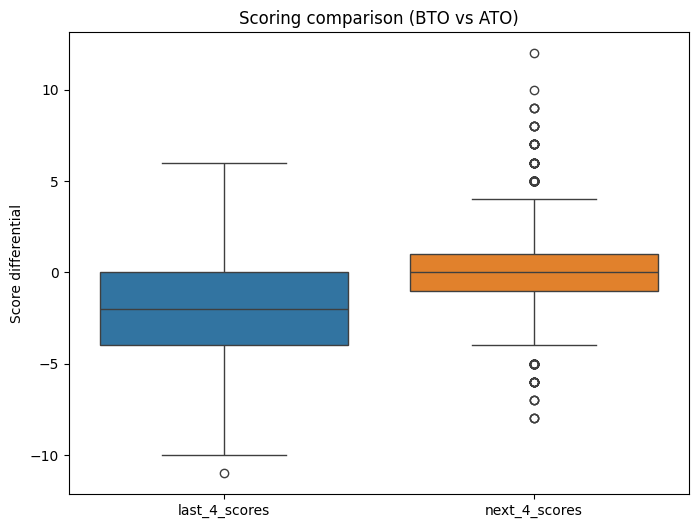

In [115]:
no_ato = df_timeouts[df_timeouts['timeout_inlast_10'] == 0]

plt.figure(figsize=(8, 6))

# Create a boxplot for both columns
sns.boxplot(data=no_ato[['last_4_scores', 'next_4_scores']])

# Labels and title
plt.ylabel('Score differential')
plt.title('Scoring comparison (BTO vs ATO)')

plt.show()

## Timeout Classification
Features that separate both types of TOs:

**Dynamic changer**: Used to reverse a team's dynamic, and transform the game's fluency into a good scenario.
- *Unsuccessful last possessions* for the team that calls the timeout
- Unfavorable last streak
- Much time remaining to end the quarter
- Much remaining possession
- Generally 1st and 3rd period, and beginning of 2nd and 4th quarters


**Tactical timeout**: Used to prepare a specific play
- *Last possessions with an average success* for the team that calls the timeout
- Few seconds of possession remaining
- 2 last minutes of a close game.
- Generally 2nd, 4th and next periods if any.

In [116]:
# Drop unneccessary columns:
df_timeouts_class = df_timeouts.drop(['idLiga', 'idPartido', 'home_TeamId', 'away_TeamId', 'idEquipoAccion',
                                      's1', 's2', 'actionNumber', 'home_TeamCode',
                                      'away_TeamCode', 'next_play', 'team_id_next_play',
                                      'team_TO', 'previousAction', 'gt', 'idPlayer',
                                      'home_next_10_success', 'away_next_10_success',
                                      'next_4_scores', 'TEAM_TO_NEXT10_SUCCESS', 'lead'], axis = 1)

### Approach 1: PCA + K-Means

In [117]:
df_proves = df_timeouts_class.copy()
df_proves = df_proves.drop(['last_4_scores', 'tiempoPosesion', 'lead_of_Team_TO', 'total_seconds'], axis = 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_proves)  # Scale and standardize features

# Set up PCA to explain 80% of the variance
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X_scaled)

# Check how many components are retained
print(f"Number of components retained: {X_pca.shape[1]}")

Number of components retained: 4


Evaluate results

In [118]:
# Apply KMeans clustering to the PCA-transformed data
kmeans = KMeans(n_clusters=2, random_state=42)
df_proves['cluster'] = kmeans.fit_predict(X_scaled)

np.round(df_proves.groupby('cluster').mean(), 2)

,period,minutes,seconds,timeout_inlast_10,TEAM_TO_LAST10_SUCCESS,timeout_Number
cluster,,,,,,
0,3.68,3.43,27.52,0.10,0.26,3.72
1,1.73,3.38,27.01,0.05,0.27,1.39


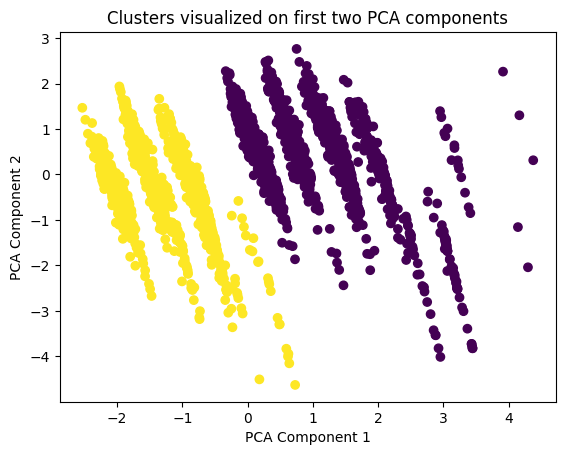

In [120]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_proves['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters visualized on first two PCA components')
plt.show()

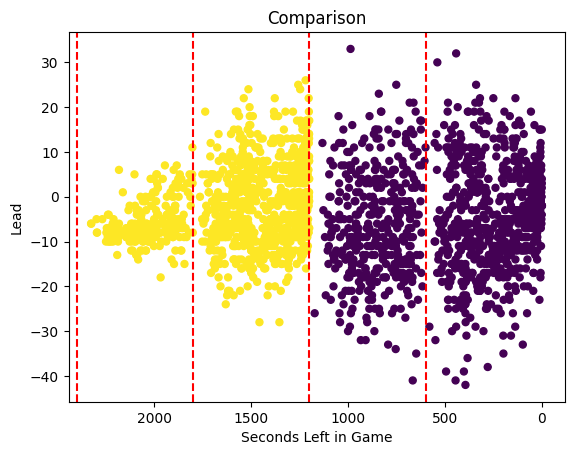

In [121]:
df_proves['lead_of_Team_TO'] = df_timeouts_class['lead_of_Team_TO']
df_proves['total_seconds'] = df_timeouts_class['total_seconds']

# Plot
plt.scatter(df_proves['total_seconds'], df_proves['lead_of_Team_TO'], c = df_proves['cluster'], s=25)

plt.axvline(600, color='red', linestyle='--')
plt.axvline(1200, color='red', linestyle='--')
plt.axvline(1800, color='red', linestyle='--')
plt.axvline(2400, color='red', linestyle='--')

plt.gca().invert_xaxis()
plt.xlabel('Seconds Left in Game')
plt.ylabel('Lead')
plt.title('Comparison')

plt.show()

In [55]:
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
print("Explained variance ratio for each component:", explained_variance_ratio)

Explained variance ratio for each component: [0.33452606 0.20551858 0.17047771 0.16376138]


In [126]:
# Get the PCA components (loadings)
loadings = pca.components_

# Convert it into a DataFrame for easier interpretation
# Each row corresponds to a principal component, and each column corresponds to a feature
pd.DataFrame(loadings, columns=df_proves.columns[:6])

,period,minutes,seconds,timeout_inlast_10,TEAM_TO_LAST10_SUCCESS,timeout_Number
0,0.649156,-0.218901,-0.049101,0.259579,0.082508,0.673854
1,0.281866,0.603609,0.327638,-0.452429,-0.460539,0.179093
2,0.006607,-0.317548,0.705940,-0.396183,0.492582,0.034221
3,0.136561,0.333862,-0.535559,-0.460143,0.608011,0.040684


In [127]:
# Calculate the importance of each feature in explaining the variance
feature_importance = np.abs(loadings) * explained_variance_ratio[:, np.newaxis]

# Sum the contributions of each feature across all components
feature_relevance = np.sum(feature_importance, axis=0)

# Convert it to a percentage
feature_relevance_percentage = feature_relevance / np.sum(feature_relevance) * 100

# Create a DataFrame to display the relevance of each feature
relevance_df = pd.DataFrame({
    'Feature': df_proves.columns[:6],
    'Relevance (%)': feature_relevance_percentage
})

# Print the relevance percentages for each feature
relevance_df.sort_values(by='Relevance (%)', ascending=False, inplace=True)
relevance_df

,Feature,Relevance (%)
3,timeout_inlast_10,17.931350
1,minutes,17.007718
4,TEAM_TO_LAST10_SUCCESS,16.991254
0,period,16.590324
2,seconds,16.214387
5,timeout_Number,15.264966


In [128]:
labels = kmeans.labels_
# Calculating silhouette score
sil_score = silhouette_score(X_pca, labels)
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.2967


### Approach 2: Manual

In [130]:
# 1 = Tactical timeout
# 0 = Dynamic timeout
# 2 = Failed to classify
def assign_TO_type(row):
  if row['minutes'] < 1:
    return 1
  if row['last_4_scores'] < -4 or row['TEAM_TO_LAST10_SUCCESS'] < 0.35:
    return 0
  if row['timeout_inlast_10'] == 1:
    return 1

  if row['period'] in [1, 3] and row['minutes'] > 3:
    return 0

  if row['period'] in [2, 4] and row['minutes'] > 5 and (row['last_4_scores'] > -3 or row['TEAM_TO_LAST10_SUCCESS'] > 0.4):
    return 1

  if row['tiempoPosesion'] < 6:
    return 1

  else:
    return 2

df_timeouts_class['cluster'] = df_timeouts_class.apply(assign_TO_type, axis = 1)
df_timeouts_class.cluster.value_counts()

,count
cluster,
0,1401
1,564
2,181


Results' evaluation:

In [131]:
df_timeouts_class.groupby('cluster').mean()

,period,tiempoPosesion,minutes,seconds,last_4_scores,lead_of_Team_TO,total_seconds,timeout_inlast_10,TEAM_TO_LAST10_SUCCESS,timeout_Number
cluster,,,,,,,,,,
0,2.688794,15.192006,4.291221,28.181299,-2.906495,-5.123483,1076.232691,0.033547,0.172828,2.513205
1,3.030142,14.985816,1.299645,24.668440,-0.911348,-0.503546,699.455674,0.203901,0.394423,3.033688
2,2.917127,22.464088,3.149171,28.541436,-0.375691,-2.502762,867.215470,0.000000,0.542050,2.674033


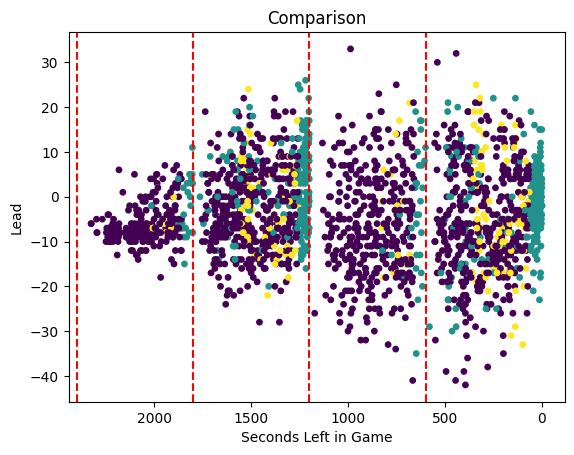

In [132]:
# Plot
plt.scatter(df_timeouts_class['total_seconds'], df_timeouts_class['lead_of_Team_TO'], c = df_timeouts_class['cluster'], s=15)

plt.axvline(600, color='red', linestyle='--')
plt.axvline(1200, color='red', linestyle='--')
plt.axvline(1800, color='red', linestyle='--')
plt.axvline(2400, color='red', linestyle='--')

plt.gca().invert_xaxis()
plt.xlabel('Seconds Left in Game')
plt.ylabel('Lead')
plt.title('Comparison')

plt.show()